# Fine-tuning Classifier LLM


In [1]:
!pip install optuna
!pip install typing
!pip install evaluate
!pip install torch
!pip install transformers
!pip install accelerate>=0.26.0

  Using cached regex-2025.7.34-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (40 kB)
  Using cached tokenizers-0.21.4-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 37.6 MB/s eta 0:00:0000:010:01
Using cached regex-2025.7.34-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (798 kB)
Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (471 kB)
Using cached tokenizers-0.21.4-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)


In [2]:
# setup - load packages
import pandas as pd
from datasets import Dataset, load_dataset
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from typing import Union, Mapping, List, Dict, Any
import evaluate
from tqdm import tqdm
import zipfile
import os
from sklearn.utils.class_weight import compute_class_weight

# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

seed = 13

cuda


## VERSION B

In [3]:
classifier_data = pd.read_csv("../data/classifier_data_B.csv")
# converting to huggingface dataset format
data = Dataset.from_pandas(classifier_data)
# splitting into train, test and validation sets

label_names = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'AfD', 'LINKE']
label2id = {label: i for i, label in enumerate(sorted(label_names))}
id2label = {i: label for label, i in label2id.items()}
def map_labels(example):
    example["label"] = label2id[example["label"]]
    return example
data = data.map(map_labels)


# shuffling data
raw_dataset = data.shuffle(seed=seed)

# 70% train, 15% test, 15% validation data
split = raw_dataset.train_test_split(test_size=0.3, seed=seed)
train_data = split["train"]
text_and_val_data = split["test"]
split = text_and_val_data.train_test_split(test_size=0.5, seed=seed)
test_data = split["train"]
val_data = split["test"]

print(f"Training samples party: {len(train_data)}")
print(f"Test samples party: {len(test_data)}")
print(f"Validation samples party: {len(val_data)}")



Map:   0%|          | 0/36117 [00:00<?, ? examples/s]

Training samples party: 25281
Test samples party: 5418
Validation samples party: 5418


In [4]:
# subset of train and val data for auto-tuning
train_data_for_tune = train_data.shuffle(seed=seed)
val_data_for_tune = val_data.shuffle(seed=seed)

# subsetting roughly 20-25% of train and vall data for tuning
train_data_for_tune = train_data_for_tune.select(range(6000))
val_data_for_tune = val_data_for_tune.select(range(1000))


In [5]:
# compute class weights
# Get raw labels as a list of integers
all_train_labels = train_data["label"]

# Compute unique class values
unique_labels = np.unique(all_train_labels)

# Compute weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=unique_labels,
    y=all_train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights

tensor([1.1977, 0.6153, 1.2799, 1.1866, 1.7240, 0.7487])

In [6]:
WINDOW_LENGTH = 512
STRIDE = 256

In [7]:
# Load Tokenizer
model_name = "deepset/gbert-base"
num_labels = 6
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    model_max_length=WINDOW_LENGTH
)


In [8]:
def sliding_window_tokenize(batch):
    texts = batch["speech_text"]
    labels = batch["label"]  # ensure this is a flat list of ints

    tokenized = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=WINDOW_LENGTH,
        stride=STRIDE,
        return_overflowing_tokens=True,
    )

    # Assign each overflow window the correct label
    #tokenized["labels"] = [label2id[labels[i]] for i in tokenized["overflow_to_sample_mapping"]]
    tokenized["labels"] = [labels[i] for i in tokenized["overflow_to_sample_mapping"]]

    return tokenized


In [9]:
tokenized_train_data = train_data.map(
    sliding_window_tokenize,
    batched=True,
    remove_columns=train_data.column_names
)

tokenized_val_data = val_data.map(
    sliding_window_tokenize,
    batched=True,
    remove_columns=train_data.column_names
)

# also tokenizing subsets

tokenized_train_data_subset = train_data_for_tune.map(
    sliding_window_tokenize,
    batched=True,
    remove_columns=train_data_for_tune.column_names
)

tokenized_val_data_subset = val_data_for_tune.map(
    sliding_window_tokenize,
    batched=True,
    remove_columns=val_data_for_tune.column_names
)

Map:   0%|          | 0/25281 [00:00<?, ? examples/s]

Map:   0%|          | 0/5418 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(
    "deepset/gbert-base",
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id
)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]

    return {
        "accuracy": acc,
        "f1": f1
    }


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.model.device)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        return (loss, outputs) if return_outputs else loss


## Hyperparameter Tuning

In [12]:
# # training arguments for hyperparameter tuning
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="no",  # don't save checkpoints during tuning
    logging_dir="./logs",
    disable_tqdm=True,  # speed up tuning
    fp16=torch.cuda.is_available(),
    report_to="none",   # optional: disable W&B or other logging
)

def hp_space(trial):
    return {
        "learning_rate": trial.suggest_categorical("learning_rate", [1e-5, 2e-5, 3e-5]),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 4),
        "weight_decay": trial.suggest_categorical("weight_decay", [0.0, 0.01, 0.05]),
    }

trainer = WeightedTrainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_train_data_subset,
    eval_dataset=tokenized_val_data_subset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

best_run = trainer.hyperparameter_search(
    direction="maximize",        # because we want to maximize accuracy
    hp_space=hp_space,
    n_trials=16,                 # how many combinations to try
    compute_objective=lambda metrics: metrics["eval_accuracy"],
    backend="optuna"
)

print("Best hyperparameters:")
print(best_run.hyperparameters)


/tmp/ipykernel_360/2176245440.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-05 18:55:23,665] A new study created in memory with name: no-name-37b3eaa2-57c5-4e09-8420-cd6dea170200
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.531762719154358, 'eval_accuracy': 0.37452107279693486, 'eval_f1': 0.3233489109684809, 'eval_runtime': 1.7135, 'eval_samples_per_second': 609.269, 'eval_steps_per_second': 76.45, 'epoch': 1.0}
{'eval_loss': 1.3261348009109497, 'eval_accuracy': 0.44731800766283525, 'eval_f1': 0.44315389161150504, 'eval_runtime': 1.6838, 'eval_samples_per_second': 620.012, 'eval_steps_per_second': 77.798, 'epoch': 2.0}
{'loss': 1.4528, 'grad_norm': 13.90131664276123, 'learning_rate': 1.1212121212121212e-05, 'epoch': 2.525252525252525}
{'eval_loss': 1.2713702917099, 'eval_accuracy': 0.48659003831417624, 'eval_f1': 0.4955530032728142, 'eval_runtime': 1.6974, 'eval_samples_per_second': 615.046, 'eval_steps_per_second': 77.175, 'epoch': 3.0}
{'eval_loss': 1.2345210313796997, 'eval_accuracy': 0.5134099616858238, 'eval_f1': 0.5214592882043614, 'eval_runtime': 1.6949, 'eval_samples_per_second': 615.983, 'eval_steps_per_second': 77.293, 'epoch': 4.0}
{'train_runtime': 105.0446, 'train_samples_per_

[I 2025-08-05 18:57:09,801] Trial 0 finished with value: 0.5134099616858238 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 4, 'weight_decay': 0.05}. Best is trial 0 with value: 0.5134099616858238.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 1.8202, 'grad_norm': 4.362800598144531, 'learning_rate': 2.369620253164557e-05, 'epoch': 0.6329113924050633}
{'eval_loss': 1.7937568426132202, 'eval_accuracy': 0.13697318007662834, 'eval_f1': 0.04015725919685482, 'eval_runtime': 1.8933, 'eval_samples_per_second': 551.422, 'eval_steps_per_second': 69.192, 'epoch': 1.0}
{'loss': 1.7946, 'grad_norm': 12.103599548339844, 'learning_rate': 1.7367088607594936e-05, 'epoch': 1.2658227848101267}
{'loss': 1.6692, 'grad_norm': 6.854897975921631, 'learning_rate': 1.1050632911392406e-05, 'epoch': 1.8987341772151898}
{'eval_loss': 1.541243076324463, 'eval_accuracy': 0.3448275862068966, 'eval_f1': 0.23713989973795357, 'eval_runtime': 1.6814, 'eval_samples_per_second': 620.913, 'eval_steps_per_second': 77.911, 'epoch': 2.0}
{'loss': 1.5045, 'grad_norm': 48.869651794433594, 'learning_rate': 4.721518987341772e-06, 'epoch': 2.5316455696202533}
{'eval_loss': 1.4957523345947266, 'eval_accuracy': 0.32950191570881227, 'eval_f1': 0.2796022594903823, '

[I 2025-08-05 18:58:57,379] Trial 1 finished with value: 0.32950191570881227 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.01}. Best is trial 0 with value: 0.5134099616858238.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.626349687576294, 'eval_accuracy': 0.2978927203065134, 'eval_f1': 0.21892347761351508, 'eval_runtime': 1.6937, 'eval_samples_per_second': 616.392, 'eval_steps_per_second': 77.344, 'epoch': 1.0}
{'eval_loss': 1.3832838535308838, 'eval_accuracy': 0.4109195402298851, 'eval_f1': 0.38736377984862497, 'eval_runtime': 1.6812, 'eval_samples_per_second': 620.997, 'eval_steps_per_second': 77.922, 'epoch': 2.0}
{'loss': 1.5389, 'grad_norm': 25.706819534301758, 'learning_rate': 7.44949494949495e-06, 'epoch': 2.525252525252525}
{'eval_loss': 1.3098632097244263, 'eval_accuracy': 0.49616858237547895, 'eval_f1': 0.47681423317050003, 'eval_runtime': 1.681, 'eval_samples_per_second': 621.06, 'eval_steps_per_second': 77.93, 'epoch': 3.0}
{'eval_loss': 1.2680814266204834, 'eval_accuracy': 0.4952107279693487, 'eval_f1': 0.4830891249717188, 'eval_runtime': 1.6804, 'eval_samples_per_second': 621.272, 'eval_steps_per_second': 77.957, 'epoch': 4.0}
{'train_runtime': 104.7102, 'train_samples_per_

[I 2025-08-05 19:00:43,119] Trial 2 finished with value: 0.4952107279693487 and parameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 4, 'weight_decay': 0.05}. Best is trial 0 with value: 0.5134099616858238.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 1.7002, 'grad_norm': 13.915099143981934, 'learning_rate': 8.433544303797469e-06, 'epoch': 0.6329113924050633}
{'eval_loss': 1.4135663509368896, 'eval_accuracy': 0.42624521072796934, 'eval_f1': 0.38657092234263013, 'eval_runtime': 1.685, 'eval_samples_per_second': 619.579, 'eval_steps_per_second': 77.744, 'epoch': 1.0}
{'loss': 1.4589, 'grad_norm': 34.44203567504883, 'learning_rate': 6.851265822784811e-06, 'epoch': 1.2658227848101267}
{'loss': 1.3164, 'grad_norm': 35.99567413330078, 'learning_rate': 5.268987341772152e-06, 'epoch': 1.8987341772151898}
{'eval_loss': 1.3113077878952026, 'eval_accuracy': 0.4454022988505747, 'eval_f1': 0.45716430012822706, 'eval_runtime': 1.6828, 'eval_samples_per_second': 620.384, 'eval_steps_per_second': 77.845, 'epoch': 2.0}
{'loss': 1.1532, 'grad_norm': 23.846620559692383, 'learning_rate': 3.6867088607594944e-06, 'epoch': 2.5316455696202533}
{'eval_loss': 1.2678334712982178, 'eval_accuracy': 0.49137931034482757, 'eval_f1': 0.49108895089143884, '

[I 2025-08-05 19:03:03,952] Trial 3 finished with value: 0.5191570881226054 and parameters: {'learning_rate': 1e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.0}. Best is trial 3 with value: 0.5191570881226054.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.552567958831787, 'eval_accuracy': 0.34770114942528735, 'eval_f1': 0.29835509908676466, 'eval_runtime': 1.6852, 'eval_samples_per_second': 619.517, 'eval_steps_per_second': 77.736, 'epoch': 1.0}
{'eval_loss': 1.3043673038482666, 'eval_accuracy': 0.4511494252873563, 'eval_f1': 0.4366705010966283, 'eval_runtime': 1.6873, 'eval_samples_per_second': 618.741, 'eval_steps_per_second': 77.639, 'epoch': 2.0}
{'loss': 1.4494, 'grad_norm': 18.417043685913086, 'learning_rate': 1.1212121212121212e-05, 'epoch': 2.525252525252525}
{'eval_loss': 1.2211287021636963, 'eval_accuracy': 0.5038314176245211, 'eval_f1': 0.5168466916124724, 'eval_runtime': 1.6886, 'eval_samples_per_second': 618.27, 'eval_steps_per_second': 77.58, 'epoch': 3.0}
{'eval_loss': 1.2109596729278564, 'eval_accuracy': 0.5172413793103449, 'eval_f1': 0.5246986677985166, 'eval_runtime': 1.6779, 'eval_samples_per_second': 622.215, 'eval_steps_per_second': 78.075, 'epoch': 4.0}
{'train_runtime': 104.2345, 'train_samples_per

[I 2025-08-05 19:04:49,151] Trial 4 finished with value: 0.5172413793103449 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 4, 'weight_decay': 0.0}. Best is trial 3 with value: 0.5191570881226054.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.7935348749160767, 'eval_accuracy': 0.13697318007662834, 'eval_f1': 0.04015725919685482, 'eval_runtime': 1.6777, 'eval_samples_per_second': 622.297, 'eval_steps_per_second': 78.085, 'epoch': 1.0}
{'loss': 1.8084, 'grad_norm': 5.677724361419678, 'learning_rate': 1.741772151898734e-05, 'epoch': 1.2658227848101267}


[I 2025-08-05 19:05:47,927] Trial 5 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.7958850860595703, 'eval_accuracy': 0.2681992337164751, 'eval_f1': 0.07049345417925477, 'eval_runtime': 1.6778, 'eval_samples_per_second': 622.25, 'eval_steps_per_second': 78.079, 'epoch': 2.0}
{'loss': 1.7529, 'grad_norm': 13.81121826171875, 'learning_rate': 1.6854430379746837e-05, 'epoch': 0.6329113924050633}
{'eval_loss': 1.4376760721206665, 'eval_accuracy': 0.3946360153256705, 'eval_f1': 0.3170401035159423, 'eval_runtime': 1.6878, 'eval_samples_per_second': 618.558, 'eval_steps_per_second': 77.616, 'epoch': 1.0}
{'loss': 1.5173, 'grad_norm': 25.151695251464844, 'learning_rate': 1.368987341772152e-05, 'epoch': 1.2658227848101267}
{'loss': 1.3604, 'grad_norm': 16.759523391723633, 'learning_rate': 1.0531645569620254e-05, 'epoch': 1.8987341772151898}
{'eval_loss': 1.3536783456802368, 'eval_accuracy': 0.44061302681992337, 'eval_f1': 0.44345610125031015, 'eval_runtime': 1.6895, 'eval_samples_per_second': 617.952, 'eval_steps_per_second': 77.54, 'epoch': 2.0}
{'loss': 1.193

[I 2025-08-05 19:08:10,347] Trial 6 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.3322138786315918, 'eval_accuracy': 0.4942528735632184, 'eval_f1': 0.48658986920351616, 'eval_runtime': 1.679, 'eval_samples_per_second': 621.783, 'eval_steps_per_second': 78.021, 'epoch': 4.0}
{'eval_loss': 1.4014105796813965, 'eval_accuracy': 0.43582375478927204, 'eval_f1': 0.3998836454138816, 'eval_runtime': 1.6763, 'eval_samples_per_second': 622.808, 'eval_steps_per_second': 78.149, 'epoch': 1.0}
{'loss': 1.5945, 'grad_norm': 21.875497817993164, 'learning_rate': 1.1645569620253165e-05, 'epoch': 1.2658227848101267}
{'eval_loss': 1.3173110485076904, 'eval_accuracy': 0.4329501915708812, 'eval_f1': 0.4219765938195547, 'eval_runtime': 1.6784, 'eval_samples_per_second': 622.006, 'eval_steps_per_second': 78.049, 'epoch': 2.0}
{'loss': 1.1939, 'grad_norm': 17.448806762695312, 'learning_rate': 3.206751054852321e-06, 'epoch': 2.5316455696202533}
{'eval_loss': 1.2493890523910522, 'eval_accuracy': 0.49137931034482757, 'eval_f1': 0.4846528735635618, 'eval_runtime': 1.6895, 'eval_

[I 2025-08-05 19:09:39,294] Trial 7 finished with value: 0.49137931034482757 and parameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3, 'weight_decay': 0.05}. Best is trial 3 with value: 0.5191570881226054.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.5353761911392212, 'eval_accuracy': 0.3764367816091954, 'eval_f1': 0.34464134884660175, 'eval_runtime': 1.6878, 'eval_samples_per_second': 618.57, 'eval_steps_per_second': 77.618, 'epoch': 1.0}
{'eval_loss': 1.297285556793213, 'eval_accuracy': 0.4492337164750958, 'eval_f1': 0.45260850852564877, 'eval_runtime': 1.69, 'eval_samples_per_second': 617.746, 'eval_steps_per_second': 77.514, 'epoch': 2.0}
{'loss': 1.4385, 'grad_norm': 12.747803688049316, 'learning_rate': 4.898989898989899e-06, 'epoch': 2.525252525252525}


[I 2025-08-05 19:10:58,176] Trial 8 pruned. 


{'eval_loss': 1.2615801095962524, 'eval_accuracy': 0.4875478927203065, 'eval_f1': 0.4884326855455001, 'eval_runtime': 1.6843, 'eval_samples_per_second': 619.838, 'eval_steps_per_second': 77.777, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 1.753, 'grad_norm': 13.125106811523438, 'learning_rate': 1.6854430379746837e-05, 'epoch': 0.6329113924050633}


[I 2025-08-05 19:11:34,224] Trial 9 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.437331199645996, 'eval_accuracy': 0.41379310344827586, 'eval_f1': 0.3575769042625423, 'eval_runtime': 1.6873, 'eval_samples_per_second': 618.757, 'eval_steps_per_second': 77.641, 'epoch': 1.0}
{'loss': 1.6993, 'grad_norm': 13.975700378417969, 'learning_rate': 8.430379746835444e-06, 'epoch': 0.6329113924050633}
{'eval_loss': 1.4213415384292603, 'eval_accuracy': 0.4272030651340996, 'eval_f1': 0.3784903596239542, 'eval_runtime': 1.6864, 'eval_samples_per_second': 619.07, 'eval_steps_per_second': 77.68, 'epoch': 1.0}
{'loss': 1.46, 'grad_norm': 35.77431869506836, 'learning_rate': 6.848101265822785e-06, 'epoch': 1.2658227848101267}
{'loss': 1.3194, 'grad_norm': 32.39641571044922, 'learning_rate': 5.265822784810127e-06, 'epoch': 1.8987341772151898}
{'eval_loss': 1.3075498342514038, 'eval_accuracy': 0.44061302681992337, 'eval_f1': 0.45326632022550456, 'eval_runtime': 1.6864, 'eval_samples_per_second': 619.081, 'eval_steps_per_second': 77.682, 'epoch': 2.0}
{'loss': 1.1531, 'gr

[I 2025-08-05 19:13:54,467] Trial 10 finished with value: 0.5220306513409961 and parameters: {'learning_rate': 1e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.0}. Best is trial 10 with value: 0.5220306513409961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 1.6971, 'grad_norm': 12.597352027893066, 'learning_rate': 8.433544303797469e-06, 'epoch': 0.6329113924050633}


[I 2025-08-05 19:14:29,948] Trial 11 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.4272879362106323, 'eval_accuracy': 0.421455938697318, 'eval_f1': 0.37443235472214526, 'eval_runtime': 1.6845, 'eval_samples_per_second': 619.786, 'eval_steps_per_second': 77.77, 'epoch': 1.0}
{'loss': 1.6964, 'grad_norm': 13.961868286132812, 'learning_rate': 8.433544303797469e-06, 'epoch': 0.6329113924050633}


[I 2025-08-05 19:15:05,482] Trial 12 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.4377565383911133, 'eval_accuracy': 0.40900383141762453, 'eval_f1': 0.3511415453938113, 'eval_runtime': 1.675, 'eval_samples_per_second': 623.286, 'eval_steps_per_second': 78.209, 'epoch': 1.0}
{'loss': 1.6982, 'grad_norm': 13.666626930236816, 'learning_rate': 8.430379746835444e-06, 'epoch': 0.6329113924050633}


[I 2025-08-05 19:15:41,063] Trial 13 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.428550124168396, 'eval_accuracy': 0.4185823754789272, 'eval_f1': 0.3697379669928605, 'eval_runtime': 1.6848, 'eval_samples_per_second': 619.668, 'eval_steps_per_second': 77.755, 'epoch': 1.0}
{'loss': 1.6997, 'grad_norm': 16.498985290527344, 'learning_rate': 8.433544303797469e-06, 'epoch': 0.6329113924050633}
{'eval_loss': 1.4195839166641235, 'eval_accuracy': 0.42911877394636017, 'eval_f1': 0.3748981273100449, 'eval_runtime': 1.6892, 'eval_samples_per_second': 618.05, 'eval_steps_per_second': 77.552, 'epoch': 1.0}
{'loss': 1.4612, 'grad_norm': 32.896724700927734, 'learning_rate': 6.851265822784811e-06, 'epoch': 1.2658227848101267}
{'loss': 1.3234, 'grad_norm': 37.60753631591797, 'learning_rate': 5.268987341772152e-06, 'epoch': 1.8987341772151898}


[I 2025-08-05 19:16:51,540] Trial 14 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.3131643533706665, 'eval_accuracy': 0.4386973180076628, 'eval_f1': 0.44907248871461863, 'eval_runtime': 1.6852, 'eval_samples_per_second': 619.496, 'eval_steps_per_second': 77.734, 'epoch': 2.0}


[I 2025-08-05 19:17:21,457] Trial 15 pruned. 


{'eval_loss': 1.5156493186950684, 'eval_accuracy': 0.38409961685823757, 'eval_f1': 0.33168506557941346, 'eval_runtime': 1.6904, 'eval_samples_per_second': 617.594, 'eval_steps_per_second': 77.495, 'epoch': 1.0}
Best hyperparameters:
{'learning_rate': 1e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.0}


In [13]:
best_run_B_df = pd.DataFrame(best_run)
best_run_B_df.to_csv("hyperpara_A.csv",index=False)

## Training with best Tuning Parameters


In [14]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=best_run.hyperparameters["learning_rate"],
    per_device_train_batch_size=best_run.hyperparameters["per_device_train_batch_size"],
    num_train_epochs=best_run.hyperparameters["num_train_epochs"],
    weight_decay=best_run.hyperparameters["weight_decay"],
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_val_data,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

trainer.train()


/tmp/ipykernel_360/2176245440.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.278400,1.209121,0.470173,0.474671
2,0.972600,0.992795,0.590187,0.604182
3,0.798600,0.964270,0.635898,0.638073
4,0.662400,0.960256,0.633251,0.636918


TrainOutput(global_step=13248, training_loss=0.9830473747806273, metrics={'train_runtime': 596.9906, 'train_samples_per_second': 177.517, 'train_steps_per_second': 22.191, 'total_flos': 2.788445862007603e+16, 'train_loss': 0.9830473747806273, 'epoch': 4.0})

In [15]:
model.save_pretrained("classifier_final_B/")
tokenizer.save_pretrained("classifier_final_B/")

('classifier_final_B/tokenizer_config.json',
 'classifier_final_B/special_tokens_map.json',
 'classifier_final_B/vocab.txt',
 'classifier_final_B/added_tokens.json',
 'classifier_final_B/tokenizer.json')

In [16]:
# model und tokenizer müssen schon geladen sein
model.eval()

def tokenize_sliding_windows(example: Dict[str, Any]) -> Dict[str, Any]:
    encoding = tokenizer(
        example["speech_text"],
        truncation=True,
        padding="max_length",
        max_length=WINDOW_LENGTH,
        stride=STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=False,
        return_tensors="pt"
    )
    return encoding

def predict_proba_for_dataset(dataset: Dataset, label_names) -> List[Dict[str, Any]]:
    results = []

    for example in tqdm(dataset):
        tokenized = tokenize_sliding_windows(example)
        input_ids = tokenized["input_ids"].to(model.device)
        attention_mask = tokenized["attention_mask"].to(model.device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

        avg_probs = probs.mean(axis=0)
        pred_idx = int(np.argmax(avg_probs))
        pred_label = label_names[pred_idx]

        results.append({
            "probs": avg_probs.tolist(),
            "label": label_names[example["label"]],  # true value
            "prediction_label": pred_label,
        })

    return results


### Validation

In [17]:
results_val_B = predict_proba_for_dataset(val_data, sorted(label_names))

100%|██████████| 5418/5418 [00:34<00:00, 156.44it/s]


In [18]:
results_val_B_df = pd.DataFrame(results_val_B)

In [19]:
results_val_B_df.to_csv("classifier_final_B_validation_results.csv",index=False)

### TEST

In [20]:
results_test_B = predict_proba_for_dataset(test_data, sorted(label_names))

100%|██████████| 5418/5418 [00:34<00:00, 157.30it/s]


In [21]:
results_test_B_df = pd.DataFrame(results_test_B)

In [22]:
results_test_B_df.to_csv("classifier_final_B_test_results.csv", index=False)

In [23]:

# Name of the zip file you want to create
zip_filename = "diffresultsB.zip"

# Create a zip file
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add model/tokenizer folder
    for root, dirs, files in os.walk("classifier_final_B/"):
        for file in files:
            filepath = os.path.join(root, file)
            arcname = os.path.relpath(filepath, start=os.path.dirname("classifier_final_B/"))
            zipf.write(filepath, arcname=arcname)

    # Add any CSVs you want
    for csv_file in ["hyperpara_B.csv", "classifier_final_B_validation_results.csv", "classifier_final_B_test_results.csv"]:
        if os.path.exists(csv_file):
            zipf.write(csv_file)

Model: val
  Accuracy: 0.6356589147286822
  Balanced Accuracy: 0.6530388904893446
  Precision: 0.6343739184509186
  Recall: 0.6530388904893446
  F1-score: 0.6395403215427818
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.86      0.83      0.84       776
     CDU/CSU       0.70      0.60      0.65      1402
         FDP       0.51      0.58      0.54       713
       GRÜNE       0.49      0.59      0.53       712
       LINKE       0.60      0.76      0.68       581
         SPD       0.64      0.56      0.60      1234

    accuracy                           0.64      5418
   macro avg       0.63      0.65      0.64      5418
weighted avg       0.65      0.64      0.64      5418



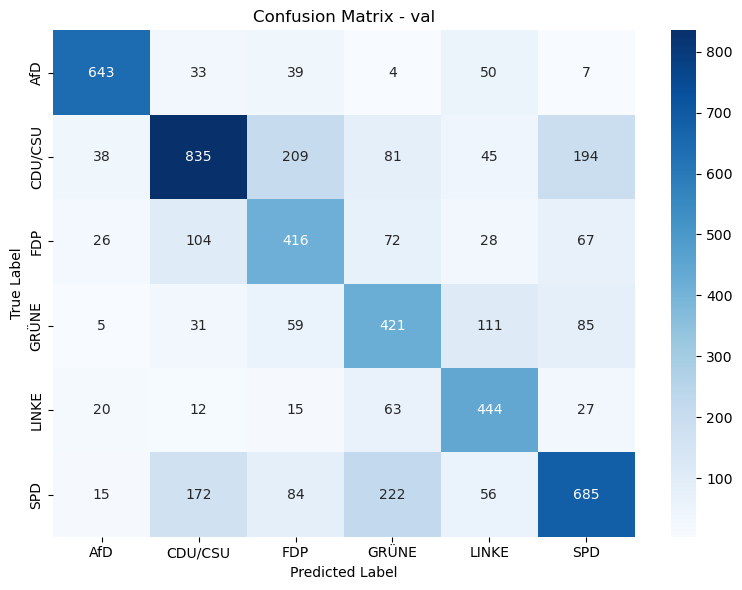

Model: val
  Accuracy: 0.6238464377999262
  Balanced Accuracy: 0.6438428153122482
  Precision: 0.6244386623208871
  Recall: 0.6438428153122482
  F1-score: 0.6294255506816466
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.83      0.80      0.82       747
     CDU/CSU       0.72      0.58      0.64      1426
         FDP       0.49      0.60      0.54       678
       GRÜNE       0.52      0.58      0.55       804
       LINKE       0.58      0.77      0.66       593
         SPD       0.60      0.54      0.57      1170

    accuracy                           0.62      5418
   macro avg       0.62      0.64      0.63      5418
weighted avg       0.64      0.62      0.63      5418



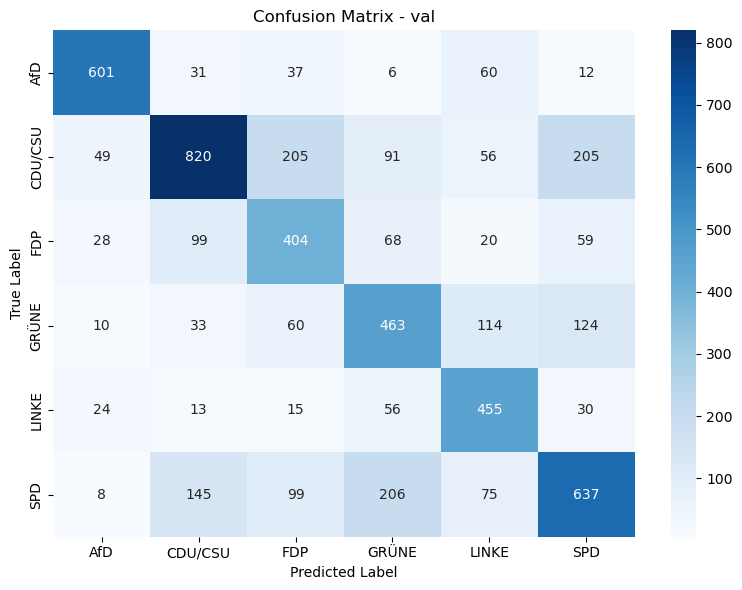

In [24]:
# define function to display eval metrics
def get_metrics(true_labels, preds, model_name):
    metrics_summary = {}

    acc = accuracy_score(true_labels, preds)
    bal_acc = balanced_accuracy_score(true_labels, preds)

    precision = precision_score(true_labels, preds, average='macro', zero_division=0)
    recall = recall_score(true_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

    label_order = sorted(set(true_labels).union(set(preds)))
    report = classification_report(true_labels, preds, labels=label_order, zero_division=0)
    metrics_summary[model_name] = {
        'acc': acc,
        'bal_acc': bal_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    # print metrics
    print(f"Model: {model_name}")
    print(f"  Accuracy: {acc}")
    print(f"  Balanced Accuracy: {bal_acc}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    print(f"  Classification Report:\n{report}")


    # Confusion Matrix
    label_order = sorted(set(true_labels).union(set(preds)))
    cm = confusion_matrix(true_labels, preds, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


    return metrics_summary

val_results = get_metrics(results_val_B_df["label"], results_val_B_df["prediction_label"], "val")
test_results = get_metrics(results_test_B_df["label"], results_test_B_df["prediction_label"], "val")
